## Imports and utility functions


In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *




In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

## Prepare data for ML exploration (read in full DB created from standard_ML_DB_preparation.ipynb)


In [5]:
DMSP_DATA_DIR = r'F:\Astra'

In [6]:
file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
df_cumulative = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
#df_cumulative = df_cumulative.set_index('Datetimes')
#df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df_cumulative.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df_cumulative = df_cumulative.drop(columns=cols_to_drop_validation)


In [6]:
X_temp = df_cumulative.drop(['ELE_TOTAL_ENERGY_FLUX', 'Datetimes'],axis = 1)
y_temp = df_cumulative['ELE_TOTAL_ENERGY_FLUX']
x = df_cumulative.drop(['ELE_TOTAL_ENERGY_FLUX', 'Datetimes'],axis = 1)
y = df_cumulative['ELE_TOTAL_ENERGY_FLUX']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.7, random_state=1)

In [8]:
X_test.shape

(1362912, 148)

In [9]:
X_train.shape

(584104, 148)

In [10]:
df_cumulative.shape
#(1947016, 149)

(1947016, 150)

In [11]:
df_cumulative.head(5)

,Datetimes,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,1987-01-12 12:57:00,51.143220,2.057827e+08,6.0,-0.246153,-0.969231,0.205104,0.97874,0.996134,0.087845,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1,1987-01-12 12:58:00,54.137207,2.509837e+08,6.0,-0.250380,-0.968148,0.205104,0.97874,0.992626,0.121216,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
2,1987-01-12 13:01:00,62.928176,4.469146e+08,6.0,-0.263031,-0.964787,0.205104,0.97874,0.968006,0.250928,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
3,1987-01-12 13:02:00,65.719631,1.934849e+10,6.0,-0.267238,-0.963630,0.205104,0.97874,0.950633,0.310316,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
4,1987-01-12 13:03:00,68.392364,3.913337e+11,6.0,-0.271440,-0.962455,0.205104,0.97874,0.924624,0.380881,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015


In [7]:
pd.set_option('display.max_columns', 150) #Expand column limit to 90
pd.set_option('display.max_rows', 150) #Expand row limits to 90

In [13]:
#df_cumulative.isnull().sum()

In [14]:
#df_cumulative.dtypes

## Lean data set

we will just be using the variable we want to predict as a determiner for the next value

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [8]:
how_much = round(1947016 * .95)
_80_percent = 1557612
how_much

1849665

In [9]:
TRAIN_SPLIT = how_much

In [10]:
tf.random.set_seed(13) #in order to reproduce

In [20]:
uni_data = df_cumulative['ELE_TOTAL_ENERGY_FLUX']
uni_data.index = df_cumulative['Datetimes'] #df_cumulative.index  
uni_data.head()

Datetimes
1987-01-12 12:57:00    2.057827e+08
1987-01-12 12:58:00    2.509837e+08
1987-01-12 13:01:00    4.469146e+08
1987-01-12 13:02:00    1.934849e+10
1987-01-12 13:03:00    3.913337e+11
Name: ELE_TOTAL_ENERGY_FLUX, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DACAB67710>],
      dtype=object)

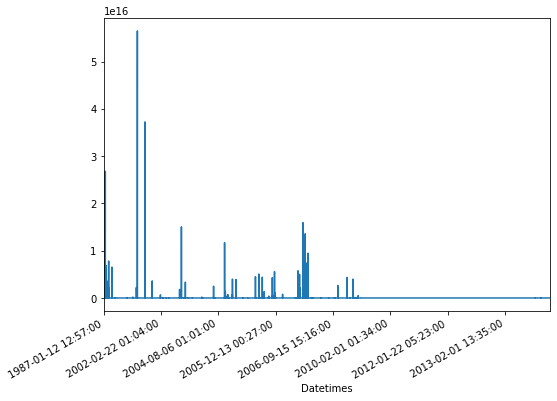

In [21]:
uni_data.plot(subplots=True)

In [21]:
uni_data = uni_data.values #convert to numpy

In [22]:
uni_data #view numpy

array([2.057827e+08, 2.509837e+08, 4.469146e+08, ..., 1.917582e+08,
       2.265864e+08, 1.160843e+09])

In [23]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_train_std

97469572948532.67

Scale

In [24]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [25]:
uni_data.shape

(1947016,)

In [26]:
univariate_past_history = 50 #look into the past how far 1440 = 1 day, 7200 = 5 day
univariate_future_target = 2 #what day to predict next day zero

In [27]:
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

In [28]:
1947016/8

243377.0

In [29]:
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

#### Past data and future target

In [30]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[-0.00373359]
 [-0.00373312]
 [-0.00373111]
 [-0.00353719]
 [ 0.00027923]
 [-0.0028289 ]
 [-0.003735  ]
 [-0.00373456]
 [-0.00373427]
 [-0.00373526]
 [-0.00367585]
 [-0.00039792]
 [ 0.00291673]
 [-0.00362932]
 [ 0.00079413]
 [-0.00366646]
 [-0.00373419]
 [-0.00373513]
 [-0.00205174]
 [-0.00373299]
 [-0.00354687]
 [-0.0037233 ]
 [-0.00341056]
 [-0.00373184]
 [-0.00272729]
 [-0.00246963]
 [-0.00284376]
 [-0.00245205]
 [-0.00299208]
 [-0.00373096]
 [-0.00373478]
 [-0.00372872]
 [-0.00336255]
 [-0.00356253]
 [-0.00167843]
 [-0.00373521]
 [-0.00338348]
 [ 0.00130461]
 [ 0.00286445]
 [-0.00365752]
 [-0.003735  ]
 [-0.00367829]
 [-0.00373489]
 [-0.00373499]
 [-0.00361479]
 [-0.00366549]
 [-0.0034644 ]
 [-0.0036432 ]
 [-0.0033753 ]
 [-0.0028575 ]]

 Target to predict
-0.0027346933542660274


In [11]:
def create_time_steps(length):
  return list(range(-length, 0))


In [12]:

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

#### Example of target

<module 'matplotlib.pyplot' from 'C:\\Users\\cgree\\.conda\\envs\\keras-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

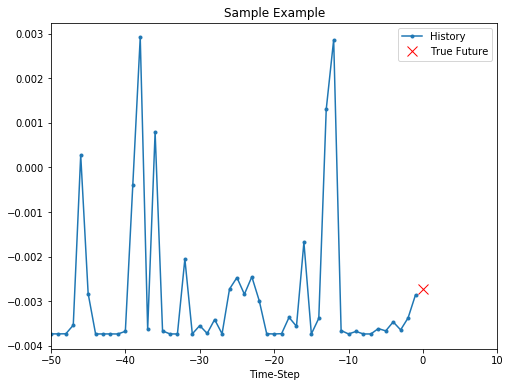

In [33]:

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [24]:
def baseline(history):
  return np.mean(history)

#### Target based on average

<module 'matplotlib.pyplot' from 'C:\\Users\\cgree\\.conda\\envs\\keras-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

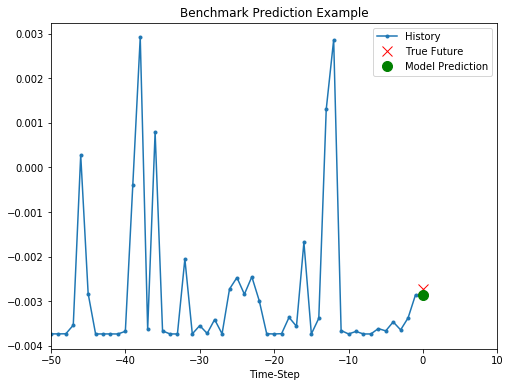

In [35]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Benchmark Prediction Example')

In [36]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [37]:
#shuffle data --- every day im suffling

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [38]:

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [39]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [40]:
EVALUATION_INTERVAL = 100 #epoch will only run for 200 steps - set back to one
EPOCHS = 20

In [41]:
simple_lstm_history = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 3s 29ms/step - loss: 0.0221 - val_loss: 7.6544e-04
Epoch 2/20
100/100 [==============================] - 1s 5ms/step - loss: 0.0063 - val_loss: 6.1735e-04
Epoch 3/20
100/100 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 6.2065e-04
Epoch 4/20
100/100 [==============================] - 1s 6ms/step - loss: 5.4710e-04 - val_loss: 5.9942e-04
Epoch 5/20
100/100 [==============================] - 1s 5ms/step - loss: 6.4189e-04 - val_loss: 6.0788e-04
Epoch 6/20
100/100 [==============================] - 1s 5ms/step - loss: 0.0796 - val_loss: 4.4099e-04
Epoch 7/20
100/100 [==============================] - 1s 5ms/step - loss: 0.0452 - val_loss: 6.1932e-04
Epoch 8/20
100/100 [==============================] - 1s 5ms/step - loss: 0.0156 - val_loss: 5.2266e-04
Epoch 9/20
100/100 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 6.4421e-04
Epoch 10/20


In [13]:
'''Plot the train/validation loss against on another'''
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

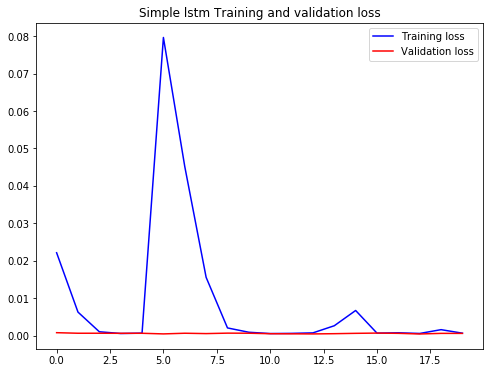

In [43]:
plot_train_history(simple_lstm_history,
                   'Simple lstm Training and validation loss')

Predicted : [-0.00389647]
Actual : -0.0026545344927500795


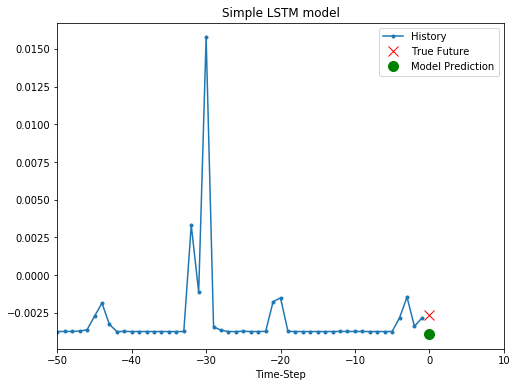

Predicted : [-0.00390687]
Actual : -0.0037286383021027814


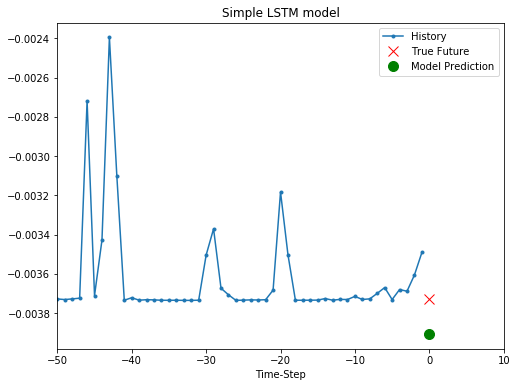

Predicted : [-0.00390667]
Actual : -0.0037002286403362097


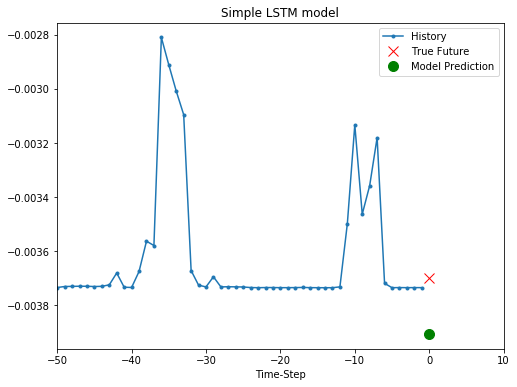

In [44]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  print('Predicted : {}'.format(simple_lstm_model.predict(x)[0]))
  print('Actual : {}'.format(y[0]))
  plot.show()

### plot all history and actual

In [14]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [46]:
train_univariate

<RepeatDataset shapes: ((None, 50, 1), (None,)), types: (tf.float64, tf.float64)>

In [47]:
#actual data we are wanting to predict
true_future = y.numpy()

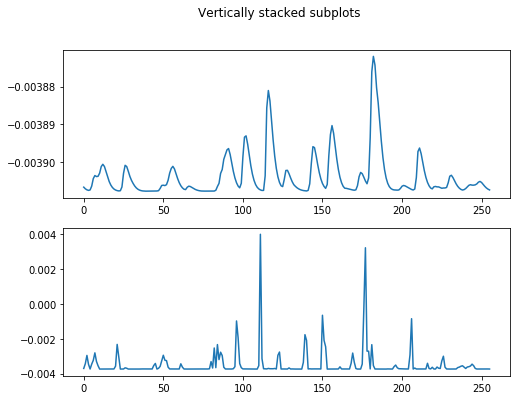

In [48]:
#train_univariate 
predicted = simple_lstm_model.predict(x)
#all_it.plot(subplots=True)
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')

axs[0].plot(predicted)
axs[1].plot(true_future)
#plt.show()

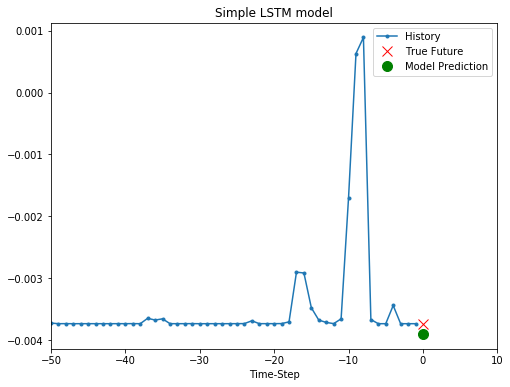

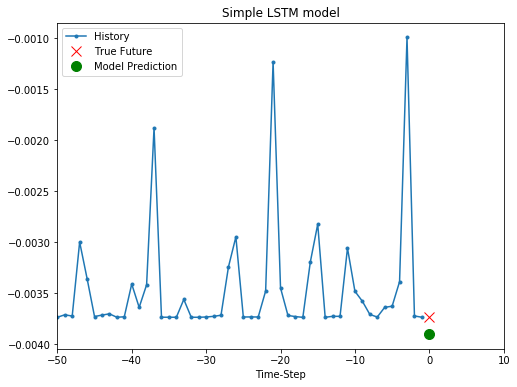

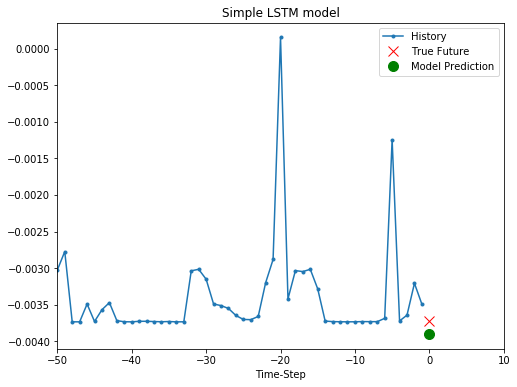

In [49]:
for w, u in train_univariate.take(3):
  plot = show_plot([w[0].numpy(), u[0].numpy(),
                    simple_lstm_model.predict(w)[0]], 0, 'Simple LSTM model')
  plot.show()

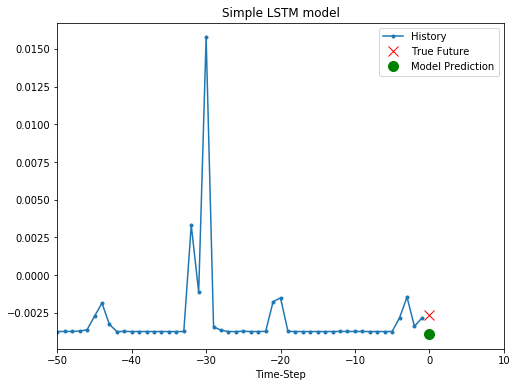

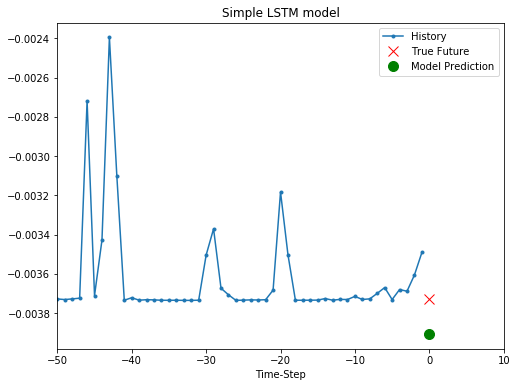

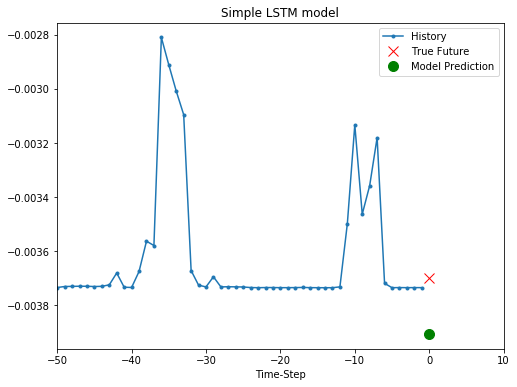

In [50]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
# for x, y in train_univariate.take(3):
#   plot = show_plot([x[0].numpy(), y[0].numpy(),
#                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  #print('Predicted : {}'.format(simple_lstm_model.predict(x)[0]))
  #print('Actual : {}'.format(y[0]))
  plot.show()

## multivariate

#### Lets test the fetures to see which are of value and which are not

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [52]:
simple_lstm_model.predict(x).shape

(256, 1)

### Skip

Feature Selection

# skip

In [125]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Calculate the VIF factors
def cal_vif(x):
    thresh = 5 #f the VIF is between 5–10, multicollinearity is likely present
    output = pd.DataFrame()
    k = x.shape[1]
    vif = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
    for i in range(1,k):
        print('Iteration no ', i)
        print(vif)
        a = np.argmax(vif)

        print('Max vif is for variable no :', a)
        if(vif[a] <=thresh):
            break
        if(i==1):
            output = x.drop(x.columns[a],axis=1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        elif(i>1):
            output = output.drop(output.columns[a], axis=1)
            vif = [variance_inflation_factor(output.values,j) for j in range(output.shape[1])]
    return(output)

selected_features = cal_vif(X_train)
selected_features.head()

Iteration no  1
[29.25905172591517, 33.146448006189935, 1.2749079831124563, 1.166220056492769, 1.08152982271241, 1.4051277814630232, 1.062726892217506, 1.125350192390002, 83502.88273126556, 33.104327128532034, 16.49383351650083, 18.905759251049805, 111118.50194435494, 47836.76543692264, 18082.442967567687, 226.8949620929314, 6878.616995296143, 666728.4865629156, 670288.5881364195, 126.79439040502395, 22.587598548742363, 52.29374726042483, 658.4158416661494, 12.062946825947892, 4.65926201932199, 5.001388972832695, 1814964.4279095237, 763543.253275701, 280123.05860539846, 37.843154456139715, 24.198383791930702, 382179.5830811643, 383270.25003750797, 36.37608936476674, 13.357532590613042, 30.0020224934737, 892.7928593089226, 14.817305779007793, 5.674320291339742, 6.0791421002631445, 1582434.1553069244, 658006.7485620268, 252290.09692267768, 53.2969996734743, 31.403328566580754, 450417.0309352027, 452401.26574162743, 46.924939961226656, 14.64440686985817, 33.96491314184365, 384.52467265386

Iteration no  4
[29.258910811491937, 33.14628749904264, 1.274904121515896, 1.166212295987507, 1.081402872856919, 1.4045698755005651, 1.0627174113595577, 1.1252960324412529, 83501.70013560141, 33.10387703858439, 16.49371041051825, 18.905040750522954, 111100.08565750944, 47828.81725937082, 18079.424856920563, 226.87945251785084, 6878.145991496318, 666694.4791659052, 670252.1120534134, 126.79374334860384, 22.58583779293352, 52.28985993397652, 658.3830038195034, 12.061580286871564, 4.658942137357204, 5.001222419076654, 5.391685478312226, 11.104598814394127, 37.836785733966266, 24.19837384446058, 382173.4352521948, 383263.953547859, 36.37241177631449, 13.357355821641375, 29.998873982403293, 892.6937286634685, 14.813935599034973, 5.673719231832176, 6.078382658874313, 5.950372727111447, 13.050963034752039, 53.28190239337536, 31.402540912019624, 450378.2488145567, 452365.279769328, 46.91835822576641, 14.64399530729336, 33.96359910763417, 384.49146170538774, 9.69045196840428, 3.389704009842963,

Iteration no  7
[29.25627179648149, 33.14165019026753, 1.2748474052895324, 1.1661743788973031, 1.0813186251083833, 1.4042138397123312, 1.0626343635630355, 1.1251817133754014, 83498.1143375158, 33.08706175949151, 16.488836852964184, 18.900835389893704, 111098.62065826045, 47828.118365997616, 18079.207303447754, 226.86164379568834, 6876.154168535169, 312517.01740570314, 309686.5604094855, 126.55088507330181, 22.58532960185395, 52.27678003653128, 658.3806769206623, 12.061481538613313, 4.658868160955564, 5.00113365937291, 5.3915635700496285, 11.103993142851365, 37.836549937839536, 24.197794632228824, 382155.9540049039, 383242.5231057153, 36.3712343457075, 13.356259962999786, 29.998651847693125, 892.6806581403388, 14.812943117866142, 5.673602133442795, 6.078040332710723, 5.949618072949689, 13.050208093359359, 53.28173319043431, 31.401889823033745, 450277.8144578299, 452257.9600496012, 46.91554233733423, 14.641816947876745, 33.962539316281905, 384.47410428483465, 9.689784740687687, 3.3895975

Iteration no  10
[29.25405549756964, 33.1403336970014, 1.2747253822959197, 1.1661677289316137, 1.0813134702366678, 1.4041247273453392, 1.062472968854471, 1.125102718170883, 83494.77669543329, 33.086298060487316, 16.48567390894405, 18.898335220824613, 111094.5547208854, 47826.29646287017, 18078.598072602766, 226.82069322284, 6875.205606029455, 301518.38218280335, 298560.47042412055, 126.53141214185109, 22.584682955603988, 52.273437906240034, 658.3423371727238, 12.05916360841433, 4.658086325435309, 5.000557405800069, 5.391045015350844, 11.103542750199857, 37.83121174406525, 24.197319195705614, 185961.5366290308, 184228.5026252957, 36.257517974395974, 13.355477893534367, 29.98867203838412, 892.647687938798, 14.807296822640913, 5.672266215042258, 6.0759152923532005, 5.949504399800015, 13.047662962031291, 53.277866146352885, 31.401130728411513, 3154.7553112223973, 46.774169209796554, 14.63898259338982, 33.927867052644814, 384.44814995164046, 9.687828349653614, 3.3890294392540783, 3.57519055

Iteration no  14
[29.25401764452716, 33.13523217564886, 1.2746084985703343, 1.1658563877880015, 1.0811780254433894, 1.4040500200552999, 1.0624594237979705, 1.1249735033600732, 83493.44297392693, 33.07899017085513, 16.482598052390035, 18.89646402387395, 111087.27793182958, 47823.245247943596, 18077.521670333565, 226.8132727161933, 6872.059913466823, 108922.03772276478, 103846.99335801805, 126.43793395428517, 22.581767495802275, 52.26925420329632, 658.3252225532844, 12.058636640328066, 4.657672211036331, 4.999949026986401, 5.389966991396235, 11.101074828154097, 37.82974827432756, 24.197043911476804, 141403.68365385462, 139222.419771934, 36.2476902077698, 13.353473667415953, 29.986901956290513, 892.6130142088969, 14.802951219606765, 5.671697374632469, 6.075048525656141, 5.9472986858574535, 13.046110260236986, 53.26706561276937, 31.40079939990127, 3153.8447426206662, 46.76352613108772, 14.63835132267943, 33.92552080864321, 384.44772283876404, 9.670471017099313, 3.3885754975940805, 3.574636

Iteration no  18
[29.249513150850703, 33.130048183358326, 1.2745742733760888, 1.1658044191904402, 1.080998554361998, 1.403659945484285, 1.0623680415407009, 1.124912818252508, 33609.94477141555, 33.07714810654358, 16.481943918558812, 18.89541990875397, 111083.47577078402, 47821.59100339139, 18076.889321456576, 226.79501072691593, 6871.189665881462, 98751.61908985203, 93640.29645462887, 126.42100033822523, 22.581318425537535, 52.267206475371594, 658.2949399254231, 11.98788364384324, 4.657569015932656, 4.999175125878421, 5.38983729932764, 11.100564700609496, 37.82537916433249, 24.195711562388095, 2102.049907469625, 36.12846163372267, 13.330365949372347, 29.730733848205144, 892.5635947378535, 14.798546419287199, 5.671437369627061, 6.074677561589898, 5.9464573797623625, 13.044541661521208, 53.24756820136557, 31.398726698171764, 3121.267192130141, 46.75409251714749, 14.628179073210319, 33.922869348734125, 384.4286444213072, 9.66926789984891, 3.388130919272, 3.574596292269342, 4.0053210943719

Iteration no  22
[29.247316968428194, 33.12787555739813, 1.2745582833434967, 1.1657522775251408, 1.0808692844517842, 1.4035736557971636, 1.0623031685100461, 1.1248689073160116, 33606.80408898767, 33.07649636565703, 16.47811108803081, 18.894798444738445, 27.589756610313813, 43.74277795695564, 226.75629771782664, 6871.079141187387, 98749.3427750854, 93638.05138175529, 126.40165552124434, 22.580235926830238, 52.26430536301399, 658.2934518296752, 11.98750078635715, 4.657307677996844, 4.9989514198600675, 5.3896295685492355, 11.099825692476164, 37.82073793038576, 24.195524961359983, 2101.957331704297, 36.1269054391347, 13.32973633829645, 29.72965382574956, 892.5452490247635, 14.798440677152712, 5.671212019474734, 6.074360460797666, 5.946315270793435, 13.04378886059958, 53.237721399213804, 31.398607015607638, 3121.208188753075, 46.74724035563366, 14.627624665675087, 33.921549570554696, 384.4064511735265, 9.669038962435772, 3.3877884173447157, 3.5745005934998266, 4.0052105883725675, 7.80278545

Iteration no  26
[29.24679920584829, 33.124868283613814, 1.2744638631924556, 1.1651891774943652, 1.080509448579193, 1.4032144853690127, 1.062285115993918, 1.1248269341364818, 486.7672981892902, 31.973086995082742, 16.477472880677688, 18.893560959854835, 27.584532108531548, 43.742024977934264, 226.70609786716597, 6868.688953296575, 3654.4882556133507, 120.96001727815613, 22.54657015555998, 50.40572942422494, 658.2894510137455, 11.979728646956955, 4.656966678513243, 4.998814864427405, 5.388451146598045, 11.098812646343333, 37.818864327144155, 24.19549602287866, 2094.834563061764, 36.12246061309876, 13.326548452809076, 29.681855046867465, 892.5432808291531, 14.797970541894063, 5.670864990239044, 6.074052300427183, 5.945580053004868, 13.043578096643328, 53.236217344187615, 31.398586559964482, 3120.328663787414, 46.74420502791202, 14.626209765294558, 33.91924097160536, 384.4040820249194, 9.668529746512462, 3.387727793757703, 3.574458730944356, 4.004228898533307, 7.801145392849042, 22.196740

Iteration no  30
[29.241645732771154, 33.122881466936015, 1.2744050586803628, 1.1650209334916164, 1.0803644846841611, 1.402906711944229, 1.0621700117969932, 1.1247355891578468, 486.7582165416703, 31.540424870768128, 16.476252385007026, 18.88444621162539, 26.874875925749436, 42.79688106890765, 226.05845599039623, 46.66823243507104, 2881.3871686369316, 119.06195048796505, 22.537717338816044, 49.73973688208155, 658.2832533569119, 11.977020154439677, 4.656887646348696, 4.99835091807363, 5.388116426031541, 11.098534304002593, 37.8174301712022, 24.193124410151135, 2092.8132533987823, 36.11610263780201, 13.325614825717278, 29.671850640601768, 892.3780962405531, 14.79563425399882, 5.670226854976121, 6.073389695570384, 5.944429288590433, 13.042958767968008, 53.23429326354336, 31.39591507760104, 3118.7717205563054, 46.73870481059259, 14.625044523553814, 33.91821616525992, 361.74517262995386, 9.66762840328092, 3.386451359547473, 3.5741635905467186, 4.003950569107694, 7.800014266070201, 22.1951611

Iteration no  34
[29.237399433484843, 33.120515288827875, 1.274392641323905, 1.1649950071425208, 1.0803011383297922, 1.4027323057844656, 1.0621359379941644, 1.1246779281997545, 486.75441394236435, 30.44424064095322, 16.475313033165143, 18.8836512947915, 26.87388259394351, 42.78670021325796, 225.93576793080214, 46.66747904227572, 577.5363514709737, 116.11315694100352, 22.506298202282917, 47.879034660789046, 658.2728293892046, 11.419539527946496, 4.656266887000338, 4.997841722240846, 5.387406004534728, 11.097176927676161, 37.76078855455895, 24.186254990457456, 630.9318099344082, 35.17597238136242, 13.306491644771924, 28.405145541884046, 892.3623628597747, 13.280047054782212, 5.668967330639024, 6.072995285909875, 5.942920415488944, 13.04185393030466, 53.09432712408697, 31.384944635222634, 44.89827892402693, 14.592718627641872, 30.473340759820207, 361.73859893355905, 9.359092034294619, 3.386091879342666, 3.57401117140876, 4.003333707018804, 7.7986979240822825, 22.13684375326998, 5.16735540

Iteration no  38
[29.235446956562583, 33.10260261074521, 1.274314586519375, 1.1649589965987666, 1.0801895320646404, 1.4026547966466583, 1.0621004740215183, 1.124644431767847, 113.67489000439787, 30.307649590030064, 16.475094858222075, 18.88265792618373, 26.872946493619903, 42.78326835705004, 104.26373789148595, 46.662192355553074, 327.161778795579, 114.69731923585194, 22.503793798413746, 47.66180068692952, 140.76904000946138, 11.31153900304362, 4.656071116518175, 4.9977147058456906, 5.386952285380442, 11.096068740631749, 37.74705708546549, 24.185658535677693, 305.9444961011898, 35.06406528250569, 13.306207987537851, 28.20105959361176, 13.275042595915448, 5.668691247960532, 6.07277561304541, 5.942412422550388, 13.040437247739753, 53.0833924006066, 31.38199706450255, 44.89158062368329, 14.591993183282424, 30.458742414348418, 265.9694710574931, 8.696033849586902, 3.3859769886626063, 3.572478410068474, 4.003032938403289, 7.797407093854425, 22.13105724373724, 5.162664455573632, 20.967256587

Iteration no  42
[29.219871635152902, 32.7776403172511, 1.274201249277243, 1.1647992057159273, 1.0801646108222704, 1.4025371582661081, 1.0620072088254349, 1.124490954967746, 61.34238083166576, 30.12436983770085, 16.471639468184744, 18.880202578491176, 26.866054198055405, 42.63227351614602, 77.41416189945166, 46.65783961661172, 65.29155716286722, 21.979565958075373, 47.233180396164045, 59.70123417572927, 11.238112020346126, 4.655919984397305, 4.997504073953335, 5.386364347022438, 11.095459163190327, 37.74464214570835, 24.18453574677085, 32.87770732539282, 35.05856925486202, 13.299516449260908, 28.089167162511433, 13.272101679366187, 5.668172601326196, 6.072576462289923, 5.942339204277993, 13.03816020899631, 53.061354430629336, 31.38026616657719, 44.88230539071417, 14.581149472694854, 30.430419825135463, 8.683237134678933, 3.385572683448241, 3.572430721868172, 4.002158212481428, 7.796134210142833, 22.115149260479527, 5.162138867824667, 20.914654678437095, 9.830776516129172, 19.4762517873

Iteration no  46
[29.218408138451263, 32.77469451862155, 1.2741136360794918, 1.164409065573605, 1.0801120666960944, 1.4022847430445553, 1.0619775286747377, 1.1244656623511158, 61.338719101329175, 30.11005577455846, 16.469529161848268, 18.877381747534443, 26.8467758930294, 42.207072531143595, 24.290125797043984, 46.63623630650935, 46.783256122223634, 21.84138867139489, 47.09949996951902, 59.699037227410656, 11.236850860526804, 4.655672978108134, 4.997117565967752, 5.3861601737951865, 11.09386027420439, 37.7430711740035, 24.17924603751121, 32.872624313846615, 35.053847669922234, 13.298340382046995, 28.085303654372066, 13.27127644035572, 5.6678309927948725, 6.071879475016668, 5.941201088473462, 13.037436941847096, 53.03411955778399, 31.373714959894237, 44.853933369307654, 14.579706486889487, 30.42179018197165, 8.680732645916903, 3.3851475189980875, 3.57219703927401, 4.0016751742625605, 7.792026439572346, 21.86028217219668, 5.161893079697755, 20.81921260273764, 9.828819787009493, 19.454673

Iteration no  51
[29.19089982353911, 32.697140848883784, 1.2737094749099058, 1.1643310850707356, 1.0780816908551711, 1.4017085619591445, 1.0618811305591527, 1.1242885557456344, 30.09339406303609, 16.46673294776356, 18.875156688336087, 26.838424307833527, 21.032290929320915, 24.195311524694034, 46.634499682442524, 30.168272418721482, 21.667913982820956, 47.01271711673359, 7.743319342452048, 11.234985017075973, 4.655173207623886, 4.996507287981016, 5.384393805467501, 11.092304866284408, 37.74095290055877, 24.177035850885513, 32.8675885949675, 35.05116897297011, 13.295345835493858, 28.079912728141206, 13.270623289968139, 5.667309492751777, 6.070768245176809, 5.940459905667033, 13.034787519110097, 53.00092862337087, 31.372999865750792, 44.77821031445316, 14.57614568495436, 30.418074810013735, 8.67958243044838, 3.384671707367392, 3.5719056919976606, 4.0013505144339865, 7.790146784890691, 21.85740733122836, 5.161559161106651, 20.75534941962144, 9.825134387094081, 19.452918160795708, 20.03513

Iteration no  56
[29.190395155815445, 32.68674187101388, 1.2733562045112863, 1.1642399080659602, 1.078017690214786, 1.39996666775805, 1.0618545043739964, 1.124227197814669, 22.586008247232776, 16.463963523349243, 18.874492480255928, 26.23442426738648, 15.059607219269031, 24.16291274744089, 30.157900334737995, 19.812640523291748, 23.637119031388558, 7.741799917265535, 11.226525433221724, 4.6546576020695, 4.995932673644007, 5.323503536096908, 11.013651286831667, 9.909534262972164, 24.095480025969657, 32.865774109893884, 29.98307251825452, 13.285196083665477, 27.129347558668254, 13.259757714301436, 5.6669873323569995, 6.070556178258338, 5.882853436670131, 12.992980320048686, 31.304110865846226, 35.843834805451486, 14.553500967880407, 30.064375421145805, 8.652098828493628, 3.3843679446983126, 3.571345210223834, 3.984456800784492, 7.774629669095136, 17.457958147080607, 5.158790930176535, 20.201644768375214, 9.823922003273868, 19.432349239688193, 20.028902552292717, 8.843720520592207, 9.8473

Iteration no  61
[29.18771714671647, 32.66449528080255, 1.2732349031792274, 1.1630628949605777, 1.0779243813824801, 1.3966501024219817, 1.0618047277460156, 1.1241837958146, 22.559328832062675, 16.45672704984433, 18.634006179983427, 8.341038957909058, 15.044842725731984, 23.894608853912654, 21.167159281228983, 19.668932734176213, 23.379378771692167, 7.741349169486308, 11.222846539367033, 4.653512914421063, 4.995813474237659, 5.322937420439973, 10.983670742172253, 9.897763649172576, 24.095072376274796, 32.814337933606225, 12.800449651125188, 12.7836219717427, 26.85201014902267, 13.240225052725707, 5.664515454054027, 6.069045837518084, 5.8768620643524425, 12.885631408933017, 31.302595347045138, 12.930936180071605, 29.263486998331466, 8.433442397476393, 3.3822528341639067, 3.5711217685606367, 3.984047444921543, 7.771893538593781, 17.436164920936484, 5.158200925187046, 17.84749864654097, 9.692170063806998, 18.665774603512272, 10.418991469097506, 8.8407651507973, 9.844186114284406, 10.643469

Iteration no  66
[27.093412712282184, 28.47106421387882, 1.2681397903718374, 1.1619382172258395, 1.0769616552296937, 1.395042036987642, 1.0604174205193295, 1.1240231180431273, 20.737301253076648, 16.231289114865643, 18.63321825944508, 8.321498853441181, 14.95764996589937, 8.81674217513971, 18.646446283388013, 19.16816740516355, 17.388746374051316, 7.716314893650114, 10.839477256796709, 4.6533224605152395, 4.995531772994888, 5.2970136598847315, 10.960444222640639, 9.860377304291582, 2.7589992417831746, 12.716422582082798, 12.568067345175459, 26.601667205669433, 13.17463184013625, 5.664098758695276, 6.067678056335628, 5.84082211100631, 12.863727267310843, 12.847387352771959, 29.227730212927643, 8.34653718360568, 3.3815524125325847, 3.5706373107056595, 3.9620683457481776, 7.765314758222226, 13.870503874761745, 4.333320883131625, 17.15544596376989, 9.604222834683664, 18.517548832035924, 10.370394600686328, 8.83997518787519, 9.84230992448362, 10.512524585528865, 20.47929115135849, 18.282431

Iteration no  72
[11.652521320883016, 1.2601424242210573, 1.1614680592858029, 1.0702044737679695, 1.387077547056627, 1.058012451379377, 1.1182489308199544, 19.88903904336887, 16.229440817721816, 6.946709599062237, 8.305101432991295, 14.934870615759424, 8.815387250726985, 18.63860388526124, 18.91004575679338, 14.721473269598842, 7.176276199623545, 7.975255992898526, 4.652573198274255, 4.994631792169016, 5.288249804744408, 10.940352498075846, 9.848990396130475, 2.7586302377016247, 12.712152281937312, 11.94849544843608, 16.827881003568375, 6.37790218877229, 5.663512290515, 6.067023015409543, 5.795295723464502, 12.762611901032523, 11.467123085255029, 7.841687592074694, 3.3813042783938716, 3.56994620717479, 3.9416609099879567, 7.734618105386544, 13.840225069428609, 4.333193868594612, 17.13375061389374, 9.49401401714075, 17.044973772874396, 10.2694629138155, 8.836252996279365, 9.840638322192895, 10.367955519913094, 11.965084196541184, 18.274943058226324, 23.08020142835814, 14.56021808284756,

Iteration no  78
[11.631368796928673, 1.2595919621391778, 1.1613788055996452, 1.0700974870640716, 1.3862128269584146, 1.0579201381807766, 1.1181958789324813, 6.166158604210701, 6.94350614252184, 8.28009006917277, 9.696840933175478, 8.796051861203686, 10.098009932366542, 11.06659774882364, 11.142107351300183, 7.1722050657282965, 7.957780996327842, 4.652531967560323, 4.993943098549982, 5.288056806126645, 10.93825682079123, 9.843198101209966, 2.7577823318536465, 12.703888515501385, 11.945889572918242, 16.77190629675924, 6.375947051155817, 5.663348325311279, 6.066546104453752, 5.7933771753094625, 12.760563411371594, 11.464366722257164, 7.789773495230656, 3.3807944729857726, 3.569094218016521, 3.9412927971797505, 7.732225141259848, 13.817693385543123, 4.3281474533170385, 14.850156951549762, 9.447110265684138, 16.949142088288436, 10.060466331812586, 8.83425166886791, 9.836512954163567, 10.366117861189462, 11.900613126193313, 16.21502054435441, 13.916068049832043, 15.459577865744663, 10.61386

Iteration no  84
[11.49445718585152, 1.2591311169388804, 1.1607674315069754, 1.0699610802018216, 1.376015238914195, 1.0578274248377204, 1.1180846744833517, 6.16518092270343, 6.943134514267977, 8.260474507393619, 9.685850273816415, 8.270513735196424, 7.839743684942119, 10.459030656303964, 10.131325609186321, 7.165324885549462, 7.525230469393936, 4.652162073100881, 4.993567858666029, 5.280789817604337, 10.91682136036436, 9.513792430299873, 2.757658961674414, 9.413341299386103, 11.594625482553381, 14.474566802700311, 6.350163831425537, 5.662956964257802, 6.06409503439966, 5.791756051080346, 12.744792656294738, 11.447826280393377, 4.342840080524418, 3.380314916298843, 3.5659142585220858, 3.8610491715148174, 7.577581626117332, 11.834523176152317, 3.910086443410079, 7.741114278584636, 7.161838483087198, 8.831800914066944, 9.835495353498349, 5.703757801335201, 11.844273980063857, 12.672453195743628, 10.610266589359787, 12.03620645868593, 6.160034637894172, 12.381394194541429, 10.5888970778763

Iteration no  91
[11.02630931519826, 1.251233774347697, 1.149776820519789, 1.0687598091304304, 1.3270007816480243, 1.0575813810677865, 1.1178112011616557, 6.164688628901446, 6.940394039306512, 4.941726487613608, 7.391340451336441, 6.156005802839809, 7.77934913224183, 10.384864623905644, 9.819970741153945, 7.10927879095945, 5.750161644768606, 4.651784356618181, 4.992799176524105, 5.105866283635017, 6.795747456897104, 5.945365502315001, 2.757342932949725, 9.350499142645829, 10.89408498140219, 6.105339613678245, 5.662270386133731, 6.0624010596405755, 4.657519617878186, 11.347046018989134, 4.137814075913811, 3.3800841568479516, 3.563821650191769, 3.6860162467244146, 7.028485064476534, 3.9089197550829438, 7.313067526386853, 4.405048174626375, 8.830103068910917, 5.918601638703854, 5.651905079060912, 8.546982098003166, 10.609224666788336, 6.158579616180626, 9.607733422844829, 9.617757634394701, 8.12708147485646, 9.414453593884604, 8.927546435460497, 6.878012242184989, 3.813555244282671, 10.14

Iteration no  99
[1.241753955796689, 1.1484335592951118, 1.067694583648953, 1.2984938671164008, 1.0547852943699476, 1.1050337916465822, 4.087777415216716, 4.527455566175352, 4.931128824807023, 7.373188687833372, 5.67754772336951, 6.101648343682044, 6.6494117978556355, 4.839035587959026, 4.288161073919228, 4.650464518128041, 4.990926274952564, 5.10362289401291, 6.4421668769437535, 5.1218925675291045, 2.7566870652923425, 6.0942774687928285, 3.3726483529850575, 5.661616885556093, 6.05876542888304, 4.639155348917963, 3.8969763360506273, 3.377155805833684, 3.5614196436722776, 3.6755877813830735, 6.989877637445761, 3.9084985508385506, 6.563291113796454, 4.246587670029421, 5.32554283450498, 5.893060441908943, 5.650080991279873, 8.53680892053617, 6.158256152956331, 7.29772109151108, 8.367005928417493, 4.957084295277114, 5.950802040125784, 6.7228438034174705, 6.8765056218189, 3.8130022589298362, 6.937082157362621, 5.40323053704267, 6.204411169816757, 7.0823517573326935]
Max vif is for variable 

Iteration no  108
[1.188388083465586, 1.1371846028437957, 1.065396723584609, 1.2391198192346407, 1.0546490117472496, 1.1047831914876205, 4.087360627608211, 3.3064581138558586, 3.574044052366993, 5.330390888982273, 5.58100585966652, 5.86555599567854, 5.477847409673979, 4.6347914745489, 4.053477663653345, 4.649107559907135, 2.3284046836727827, 5.06676836631408, 5.855267571424057, 5.0337770319386035, 2.75225254572108, 5.121552997450957, 3.3021070055066115, 5.6602263076053445, 4.583053505204406, 2.317725889166049, 3.376297467899068, 3.152095888764188, 2.8128803537872433, 3.7358069364166644, 3.884366405658718, 5.324399744792422, 4.113247868303123, 3.238027585072576, 4.639433893884421, 3.9765608852561942, 5.949884475469818, 3.37274416704403, 3.5424788965040617, 5.388406118529368, 5.180685672255306]
Max vif is for variable no : 36
Iteration no  109
[1.1883679350139593, 1.1371539010813627, 1.0653947584094061, 1.2391124593825027, 1.0546397357239514, 1.1047813525963506, 3.0086554729445365, 3.306

,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,By,Bx,AL,AU,SymH,F107_6hr,Bz_6hr,By_6hr,Bx_6hr,AL_6hr,SymH_6hr,PC_6hr,borovsky_6hr,Bz_5hr,AL_5hr,Bz_3hr,By_3hr,Bx_3hr,AL_3hr,PC_3hr,Bz_1hr,By_1hr,Bx_1hr,AL_1hr,borovsky_45min,Bz_30min,PC_30min,PC_10min,borovsky_10min,Bz_5min
891167,0.999914,0.013090,0.471160,-0.882048,0.570050,0.821610,0.29,-3.90,-46.0,45.0,-9.0,77.75,0.071750,-3.225000,0.980833,-73.916667,-9.166667,1.668333,33665.123136,0.076667,-61.750000,1.656667,-1.280000,-2.418333,-45.666667,0.330000,2.121667,-0.326667,-3.451667,-57.833333,14637.147155,0.70,-0.00,-0.17,4543.668056,1.56
78539,0.386711,0.922201,-0.741222,-0.671260,0.496561,-0.868002,0.20,-2.50,-47.0,15.0,-34.0,159.90,4.752500,-0.844167,-4.505833,-38.166667,-21.666667,-0.406667,1267.946020,4.449167,-35.166667,2.195000,0.971667,-3.258333,-72.333333,-0.748333,1.506667,0.471667,-2.358333,-28.000000,735.942799,1.60,-0.52,-0.40,632.476809,1.06
1379837,0.537300,0.843391,0.970064,0.242850,-0.893079,-0.449900,5.85,0.31,-13.0,10.0,-3.0,89.20,4.590833,3.485833,0.887500,-272.916667,-13.833333,2.439167,6078.980833,7.145833,-21.416667,6.871667,3.935000,1.131667,-16.500000,-0.063333,4.521667,3.576667,1.625000,-14.166667,7556.465982,1.47,0.26,0.22,6781.011694,2.77
593578,0.577145,0.816642,0.705584,-0.708627,0.392153,-0.919900,-2.85,-0.61,-71.0,135.0,-19.0,117.90,-2.132500,-4.579167,0.747500,-75.333333,-16.416667,0.229167,25638.391125,-2.805000,-64.333333,-3.170000,-4.778333,1.661667,-232.500000,0.863333,-1.986667,-3.913333,-1.465000,-119.166667,34393.053141,-2.63,1.11,1.14,35398.771930,-2.94
58893,0.710185,-0.704015,-0.711657,0.702527,-0.978148,-0.207912,2.82,1.50,-44.0,17.0,-1.0,202.40,3.438333,1.471667,1.948333,-6.916667,10.750000,-0.124167,918.162274,2.622500,-7.833333,-0.756667,2.515000,2.746667,0.666667,0.058333,-0.071667,3.135000,1.795000,-4.166667,9338.442057,-0.41,0.19,0.31,11551.991247,-0.11


In [7]:
# selected_features.columns

NameError: name 'selected_features' is not defined

In [295]:
# selected_features.shape

NameError: name 'selected_features' is not defined

## Multiple variables

In [43]:
features_considered = ['sin_ut', 'ELE_TOTAL_ENERGY_FLUX','cos_ut', 'sin_doy', 'cos_doy', 'sin_SC_AACGM_LTIME','cos_SC_AACGM_LTIME', 'By', 'Bx', 'AL', 'AU', 'SymH', 'F107_6hr',
       'Bz_6hr', 'By_6hr', 'Bx_6hr', 'AL_6hr', 'SymH_6hr', 'PC_6hr',
       'borovsky_6hr', 'Bz_5hr', 'AL_5hr', 'Bz_3hr', 'By_3hr', 'Bx_3hr',
       'AL_3hr', 'PC_3hr', 'Bz_1hr', 'By_1hr', 'Bx_1hr', 'AL_1hr',
       'borovsky_45min', 'Bz_30min', 'PC_30min', 'PC_10min', 'borovsky_10min',
       'Bz_5min']

In [44]:
len(features_considered)

37

In [225]:
features = df_cumulative[features_considered]
features.index = df_cumulative['Datetimes']
features.head()

,sin_ut,ELE_TOTAL_ENERGY_FLUX,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,By,Bx,AL,AU,SymH,F107_6hr,Bz_6hr,By_6hr,Bx_6hr,AL_6hr,SymH_6hr,PC_6hr,borovsky_6hr,Bz_5hr,AL_5hr,Bz_3hr,By_3hr,Bx_3hr,AL_3hr,PC_3hr,Bz_1hr,By_1hr,Bx_1hr,AL_1hr,borovsky_45min,Bz_30min,PC_30min,PC_10min,borovsky_10min,Bz_5min
Datetimes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1987-01-12 12:57:00,-0.246153,2.057827e+08,-0.969231,0.205104,0.97874,0.996134,0.087845,6.40,-3.49,-58.0,24.0,3.0,68.9,3.143333,5.213333,-2.877500,-18.75,-7.916667,1.341667,13556.319494,1.155,-4.25,3.435000,9.126667,0.365000,-48.666667,0.270,3.980000,4.960000,0.578333,-169.5,19981.769117,0.56,0.51,0.71,19335.344017,1.51
1987-01-12 12:58:00,-0.250380,2.509837e+08,-0.968148,0.205104,0.97874,0.992626,0.121216,6.40,-3.49,-58.0,24.0,3.0,68.9,3.143333,5.213333,-2.877500,-18.75,-7.916667,1.341667,13556.319494,1.155,-4.25,3.435000,9.126667,0.365000,-48.666667,0.270,3.980000,4.960000,0.578333,-169.5,19981.769117,0.56,0.51,0.71,19335.344017,1.51
1987-01-12 13:01:00,-0.263031,4.469146e+08,-0.964787,0.205104,0.97874,0.968006,0.250928,6.49,-3.20,-75.0,21.0,1.0,68.9,2.975833,5.298333,-2.364167,-14.50,-6.583333,1.236667,15091.975065,1.095,-6.50,2.738333,9.205000,-0.813333,-53.333333,0.295,3.483333,5.083333,0.345000,-152.5,11208.996401,1.14,0.52,0.77,17439.640589,2.78
1987-01-12 13:02:00,-0.267238,1.934849e+10,-0.963630,0.205104,0.97874,0.950633,0.310316,6.49,-3.20,-75.0,21.0,1.0,68.9,2.975833,5.298333,-2.364167,-14.50,-6.583333,1.236667,15091.975065,1.095,-6.50,2.738333,9.205000,-0.813333,-53.333333,0.295,3.483333,5.083333,0.345000,-152.5,11208.996401,1.14,0.52,0.77,17439.640589,2.78
1987-01-12 13:03:00,-0.271440,3.913337e+11,-0.962455,0.205104,0.97874,0.924624,0.380881,6.49,-3.20,-75.0,21.0,1.0,68.9,2.975833,5.298333,-2.364167,-14.50,-6.583333,1.236667,15091.975065,1.095,-6.50,2.738333,9.205000,-0.813333,-53.333333,0.295,3.483333,5.083333,0.345000,-152.5,11208.996401,1.14,0.52,0.77,17439.640589,2.78


# Transoform data

We need to transform some of our data it seems to be messing with predicitons we will apply a simple box cox transofmation to get the data in a better spot, but first we will need to apply transformations for the negatives,

In [226]:
fdes = features.describe()

In [227]:
# fdes.sin_ut

count    1.947016e+06
mean    -1.539582e-02
std      7.043970e-01
min     -1.000000e+00
25%     -7.163019e-01
50%     -3.053851e-02
75%      6.883546e-01
max      1.000000e+00
Name: sin_ut, dtype: float64

In [228]:
# abs(fdes['sin_ut'][3])

1.0

In [229]:
# features.columns

Index(['sin_ut', 'ELE_TOTAL_ENERGY_FLUX', 'cos_ut', 'sin_doy', 'cos_doy',
       'sin_SC_AACGM_LTIME', 'cos_SC_AACGM_LTIME', 'By', 'Bx', 'AL', 'AU',
       'SymH', 'F107_6hr', 'Bz_6hr', 'By_6hr', 'Bx_6hr', 'AL_6hr', 'SymH_6hr',
       'PC_6hr', 'borovsky_6hr', 'Bz_5hr', 'AL_5hr', 'Bz_3hr', 'By_3hr',
       'Bx_3hr', 'AL_3hr', 'PC_3hr', 'Bz_1hr', 'By_1hr', 'Bx_1hr', 'AL_1hr',
       'borovsky_45min', 'Bz_30min', 'PC_30min', 'PC_10min', 'borovsky_10min',
       'Bz_5min'],
      dtype='object')

In [230]:
# abs(fdes['sin_ut'][3])

1.0

In [231]:
#box cox 
#we needed to get rid of the negatives so we used the absolut value of the min to add to all the rows of the data
from scipy.stats import boxcox

def box_cox(df, column_name, fdes):
    for column in column_name:
        df[column] += abs(fdes[column][3])
        df[column] = boxcox(df[column] + 1 )[0]
    return df


In [232]:
column_name = ['sin_ut', 'ELE_TOTAL_ENERGY_FLUX', 'cos_ut', 'sin_doy', 'cos_doy',
       'sin_SC_AACGM_LTIME', 'cos_SC_AACGM_LTIME', 'By', 'Bx', 'AL', 'AU',
       'SymH', 'F107_6hr', 'Bz_6hr', 'By_6hr', 'Bx_6hr', 'AL_6hr', 'SymH_6hr',
       'PC_6hr', 'borovsky_6hr', 'Bz_5hr', 'AL_5hr', 'Bz_3hr', 'By_3hr',
       'Bx_3hr', 'AL_3hr', 'PC_3hr', 'Bz_1hr', 'By_1hr', 'Bx_1hr', 'AL_1hr',
       'borovsky_45min', 'Bz_30min', 'PC_30min', 'PC_10min', 'borovsky_10min',
       'Bz_5min']
box_cox(features, column_name, fdes)

C:\Users\cgree\.conda\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\cgree\.conda\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sin_ut,ELE_TOTAL_ENERGY_FLUX,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,By,Bx,AL,AU,SymH,F107_6hr,Bz_6hr,By_6hr,Bx_6hr,AL_6hr,SymH_6hr,PC_6hr,borovsky_6hr,Bz_5hr,AL_5hr,Bz_3hr,By_3hr,Bx_3hr,AL_3hr,PC_3hr,Bz_1hr,By_1hr,Bx_1hr,AL_1hr,borovsky_45min,Bz_30min,PC_30min,PC_10min,borovsky_10min,Bz_5min
Datetimes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1987-01-12 12:57:00,0.655452,7.964006,0.030578,0.919241,1.542562,1.612416,0.845804,34.524516,12.033077,9.157549e+31,1.672400,14812.156967,0.572813,3.449109,29.647898,13.111077,2.684738e+26,3.475562e+07,1.173684,104.942556,3.129398,1.126662e+27,3.584483,39.433735,15.308986,8.272594e+44,1.287963,3.954365,28.026497,14.512975,1.307267e+37,128.357214,3.527793,1.277370,1.304830,128.393384,3.747491
1987-01-12 12:58:00,0.652194,7.987429,0.031647,0.919241,1.542562,1.609995,0.866671,34.524516,12.033077,9.157549e+31,1.672400,14812.156967,0.572813,3.449109,29.647898,13.111077,2.684738e+26,3.475562e+07,1.173684,104.942556,3.129398,1.126662e+27,3.584483,39.433735,15.308986,8.272594e+44,1.287963,3.954365,28.026497,14.512975,1.307267e+37,128.357214,3.527793,1.277370,1.304830,128.393384,3.747491
1987-01-12 13:01:00,0.642422,8.052905,0.034962,0.919241,1.542562,1.592981,0.945868,34.628607,12.261466,7.509142e+31,1.665225,14368.925779,0.572813,3.428197,29.743603,13.507895,2.790635e+26,3.566664e+07,1.171310,109.576876,3.121761,1.102726e+27,3.498178,39.520996,14.437784,7.883418e+44,1.288897,3.873758,28.161239,14.327822,1.597712e+37,101.368593,3.642780,1.277658,1.306571,123.083494,3.974457
1987-01-12 13:02:00,0.639165,8.394043,0.036103,0.919241,1.542562,1.580947,0.981168,34.628607,12.261466,7.509142e+31,1.665225,14368.925779,0.572813,3.428197,29.743603,13.507895,2.790635e+26,3.566664e+07,1.171310,109.576876,3.121761,1.102726e+27,3.498178,39.520996,14.437784,7.883418e+44,1.288897,3.873758,28.161239,14.327822,1.597712e+37,101.368593,3.642780,1.277658,1.306571,123.083494,3.974457
1987-01-12 13:03:00,0.635908,8.581180,0.037261,0.919241,1.542562,1.562886,1.022374,34.628607,12.261466,7.509142e+31,1.665225,14368.925779,0.572813,3.428197,29.743603,13.507895,2.790635e+26,3.566664e+07,1.171310,109.576876,3.121761,1.102726e+27,3.498178,39.520996,14.437784,7.883418e+44,1.288897,3.873758,28.161239,14.327822,1.597712e+37,101.368593,3.642780,1.277658,1.306571,123.083494,3.974457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 22:50:00,0.613124,7.973623,1.516100,0.790607,1.556297,0.092353,1.046496,24.788728,19.721561,1.441064e+32,1.715054,12056.657461,0.572865,3.286253,25.281347,16.956454,1.326036e+26,3.973133e+07,1.157108,115.244604,2.967690,4.954989e+26,3.166699,30.576927,19.057033,1.238202e+45,1.278978,3.518524,21.085881,18.674245,7.500684e+37,77.080268,3.837356,1.265125,1.276567,91.281236,3.806191
2014-12-31 22:51:00,0.616377,8.010884,1.516936,0.790607,1.556297,0.083779,1.035335,24.788728,19.721561,1.441064e+32,1.715054,12056.657461,0.572865,3.286253,25.281347,16.956454,1.326036e+26,3.973133e+07,1.157108,115.244604,2.967690,4.954989e+26,3.166699,30.576927,19.057033,1.238202e+45,1.278978,3.518524,21.085881,18.674245,7.500684e+37,77.080268,3.837356,1.265125,1.276567,91.281236,3.806191
2014-12-31 22:52:00,0.619631,7.955571,1.517759,0.790607,1.556297,0.076379,1.025135,24.788728,19.721561,1.441064e+32,1.715054,12056.657461,0.572865,3.286253,25.281347,16.956454,1.326036e+26,3.973133e+07,1.157108,115.244604,2.967690,4.954989e+26,3.166699,30.576927,19.057033,1.238202e+45,1.278978,3.518524,21.085881,18.674245,7.500684e+37,77.080268,3.837356,1.265125,1.276567,91.281236,3.806191


In [233]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
data_std

array([5.23689414e-01, 2.20729142e-01, 5.45293399e-01, 4.23723810e-01,
       5.44589271e-01, 6.52800734e-01, 3.91750589e-01, 5.18170677e+00,
       3.08962461e+00, 5.07191629e+31, 5.05481684e-02, 3.12721878e+03,
       1.05405681e-05, 4.46438941e-01, 4.86432350e+00, 2.96059874e+00,
       9.09902990e+25, 1.05318232e+07, 2.70432358e-02, 3.83875248e+01,
       4.01701729e-01, 3.33657387e+26, 4.53157883e-01, 4.84192256e+00,
       2.87469571e+00, 3.88495086e+44, 3.82739715e-02, 6.16568386e-01,
       4.76087409e+00, 3.08747212e+00, 2.44411182e+37, 4.63812244e+01,
       6.63364748e-01, 3.22691852e-02, 3.40489656e-02, 4.71132238e+01,
       6.46330183e-01])

# added above for box cox transform

In [234]:
features.values

array([[6.55451774e-01, 7.96400643e+00, 3.05776770e-02, ...,
        1.30482976e+00, 1.28393384e+02, 3.74749054e+00],
       [6.52194287e-01, 7.98742894e+00, 3.16473332e-02, ...,
        1.30482976e+00, 1.28393384e+02, 3.74749054e+00],
       [6.42422200e-01, 8.05290487e+00, 3.49624948e-02, ...,
        1.30657134e+00, 1.23083494e+02, 3.97445727e+00],
       ...,
       [6.19630829e-01, 7.95557111e+00, 1.51775943e+00, ...,
        1.27656712e+00, 9.12812362e+01, 3.80619075e+00],
       [6.22885304e-01, 7.97542314e+00, 1.51857134e+00, ...,
        1.27656712e+00, 9.12812362e+01, 3.80619075e+00],
       [6.26140363e-01, 8.15293175e+00, 1.51937142e+00, ...,
        1.27656712e+00, 9.12812362e+01, 3.80619075e+00]])

In [235]:
dataset = (dataset-data_mean)/data_std

In [236]:
dataset.shape

(1947016, 37)

In [237]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [238]:
past_history = 60 #past data points (60 min in)
future_target = 5 #what data point predict(30 min in)
STEP = 3 #adjustment for iterations/steps similar to epocks
EVALUATION_INTERVAL = 75 #epoch will only run for 200 steps
EPOCHS = 75
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [239]:
# x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
#                                                    TRAIN_SPLIT, past_history,
#                                                    future_target, STEP,
#                                                    single_step=True)
# x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
#                                                TRAIN_SPLIT, None, past_history,
#                                                future_target, STEP,
#                                                single_step=True)

KeyboardInterrupt: 

In [45]:
# y_train_single

array([-0.00349672, -0.00373538, -0.00373357, ..., -0.00373177,
       -0.00370932, -0.00361035])

In [46]:
# print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (20, 3)


In [47]:
# train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
# train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
# val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [45]:
# single_step_model = tf.keras.models.Sequential()
# single_step_model.add(tf.keras.layers.LSTM(32,
#                                            input_shape=x_train_single.shape[-2:]))
# single_step_model.add(tf.keras.layers.Dense(1))

# single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [46]:
# for x, y in val_data_single.take(1):
#   print(single_step_model.predict(x).shape)

NameError: name 'single_step_model' is not defined

#### Train

In [69]:
# train_predict = model.predict(X_train)
# test_predict = model.predict(X_test)

In [ ]:
# single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
#                                             steps_per_epoch=EVALUATION_INTERVAL,
#                                             validation_data=val_data_single,
#                                             validation_steps=50)

Train for 75 steps, validate for 50 steps
Epoch 1/75
75/75 [==============================] - 7s 91ms/step - loss: 0.1095 - val_loss: 0.0626
Epoch 2/75
75/75 [==============================] - 1s 10ms/step - loss: 0.0447 - val_loss: 0.0447
Epoch 3/75
75/75 [==============================] - 1s 11ms/step - loss: 0.0288 - val_loss: 0.0363
Epoch 4/75
75/75 [==============================] - 1s 11ms/step - loss: 0.0197 - val_loss: 0.0308
Epoch 5/75
75/75 [==============================] - 1s 11ms/step - loss: 0.0156 - val_loss: 0.0283
Epoch 6/75
75/75 [==============================] - 1s 11ms/step - loss: 0.0127 - val_loss: 0.0260
Epoch 7/75
75/75 [==============================] - 1s 12ms/step - loss: 0.0123 - val_loss: 0.0247
Epoch 8/75
75/75 [==============================] - 1s 12ms/step - loss: 0.1339 - val_loss: 0.0198
Epoch 9/75
75/75 [==============================] - 1s 12ms/step - loss: 0.0208 - val_loss: 0.0115
Epoch 10/75
75/75 [==============================] - 1s 11ms/step -

In [24]:
'''Plot the train/validation loss against on another'''
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
# plot_train_history(single_step_history,
#                    'Single Step Training and validation loss')

In [ ]:
# for x, y in val_data_single.take(3):
#   plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
#                     single_step_model.predict(x)[0]], (2),
#                    'Single Step Prediction')
#   plot.show()
#   print('Predicted : {}'.format(single_step_model.predict(x)[0]))
#   print('Actual : {}'.format(y[0]))

## Multi

In [465]:
past_history = 720 #past data points (60 min in) 720
#future_target = 5 #what data point predict(30 min in)
STEP = 1 #adjustment for iterations/steps similar to epocks
EVALUATION_INTERVAL = 20 #epoch will only run for 200 steps
EPOCHS = 10
BATCH_SIZE = 60
BUFFER_SIZE = 1000

In [466]:
future_target = 15 #samples from the last 5 points

In [467]:
#redefine the dataset
how_much = round(500000 * .5)
#dataset= round(1947016 * .95)
TRAIN_SPLIT = how_much

In [468]:
dataset.shape

(500000, 37)

In [469]:
dataset = dataset[:500000]
dataset.shape

(500000, 37)

In [470]:
dataset

array([[-2.41181093e-01, -8.98379795e-01, -1.45071014e+00, ...,
         1.99356205e-01,  4.90748513e-01,  1.82080439e-01],
       [-2.47401359e-01, -7.92265555e-01, -1.44874852e+00, ...,
         1.99356205e-01,  4.90748513e-01,  1.82080439e-01],
       [-2.66061439e-01, -4.95630832e-01, -1.44266893e+00, ...,
         2.50505591e-01,  3.78043636e-01,  5.33242645e-01],
       ...,
       [ 4.46772176e-01,  1.84256892e+00,  1.29050701e+00, ...,
         1.02323254e+00,  1.33838704e+00,  1.22023299e-03],
       [ 4.52300388e-01,  1.61547822e+00,  1.28921383e+00, ...,
         1.02323254e+00,  1.33838704e+00,  1.22023299e-03],
       [ 4.57817455e-01, -7.97726111e-01,  1.28789884e+00, ...,
         1.07429740e+00,  5.61409115e-01, -2.92828149e-01]])

In [471]:
#split data 
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)

MemoryError: Unable to allocate array with shape (720, 37) and data type float64

In [ ]:
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [455]:
x_train_multi.shape

(249975, 25, 37)

In [456]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (25, 37)

 Target to predict : (15,)


In [457]:
#tf.data to shuffle, batch, and cache the dataset.
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [458]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(18, 12))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

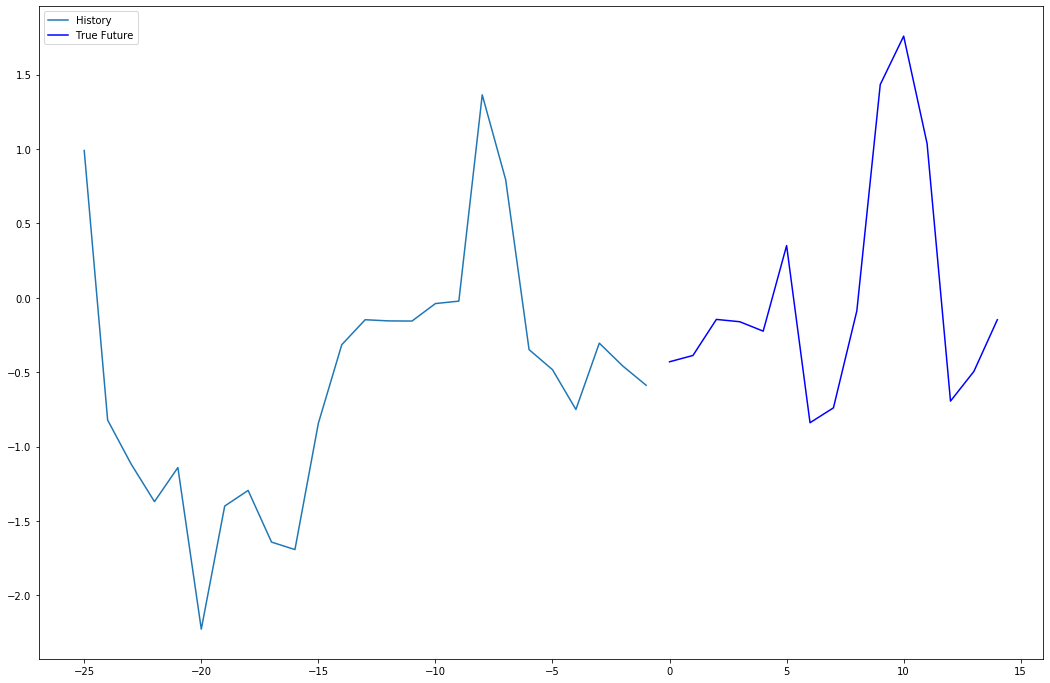

In [459]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [460]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(5,return_sequences=True,input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(15, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(15))
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae',metrics=['accuracy'])
#Optimier
#tf.keras.optimizers.RMSprop(clipvalue=1.0)
log_dir = r"C:\Users\cgree\Documents\logs\fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [461]:
#input shape. how many variables?
x_train_multi.shape[-2:]

(25, 37)

In [462]:
for x, y in val_data_multi.take(1):
  print(x.shape)
  print(multi_step_model.predict(x).shape)
  print(y.shape)

(60, 25, 37)
(60, 15)
(60, 15)


In [463]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=[tensorboard_callback])

Train for 20 steps, validate for 50 steps
Epoch 1/10
20/20 [==============================] - 8s 410ms/step - loss: 0.9609 - accuracy: 0.0650 - val_loss: 0.8856 - val_accuracy: 0.0640
Epoch 2/10
20/20 [==============================] - 2s 91ms/step - loss: 0.9411 - accuracy: 0.0617 - val_loss: 0.8842 - val_accuracy: 0.0673
Epoch 3/10
20/20 [==============================] - 2s 91ms/step - loss: 0.9342 - accuracy: 0.0692 - val_loss: 0.8826 - val_accuracy: 0.0630
Epoch 4/10
20/20 [==============================] - 2s 92ms/step - loss: 0.9408 - accuracy: 0.0608 - val_loss: 0.8835 - val_accuracy: 0.0650
Epoch 5/10
20/20 [==============================] - 2s 90ms/step - loss: 0.9293 - accuracy: 0.0667 - val_loss: 0.8841 - val_accuracy: 0.0620
Epoch 6/10
20/20 [==============================] - 2s 90ms/step - loss: 0.9239 - accuracy: 0.0717 - val_loss: 0.8856 - val_accuracy: 0.0627
Epoch 7/10
20/20 [==============================] - 2s 91ms/step - loss: 0.9109 - accuracy: 0.0708 - val_loss: 

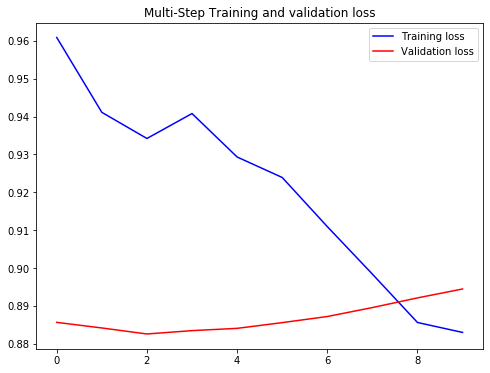

In [464]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

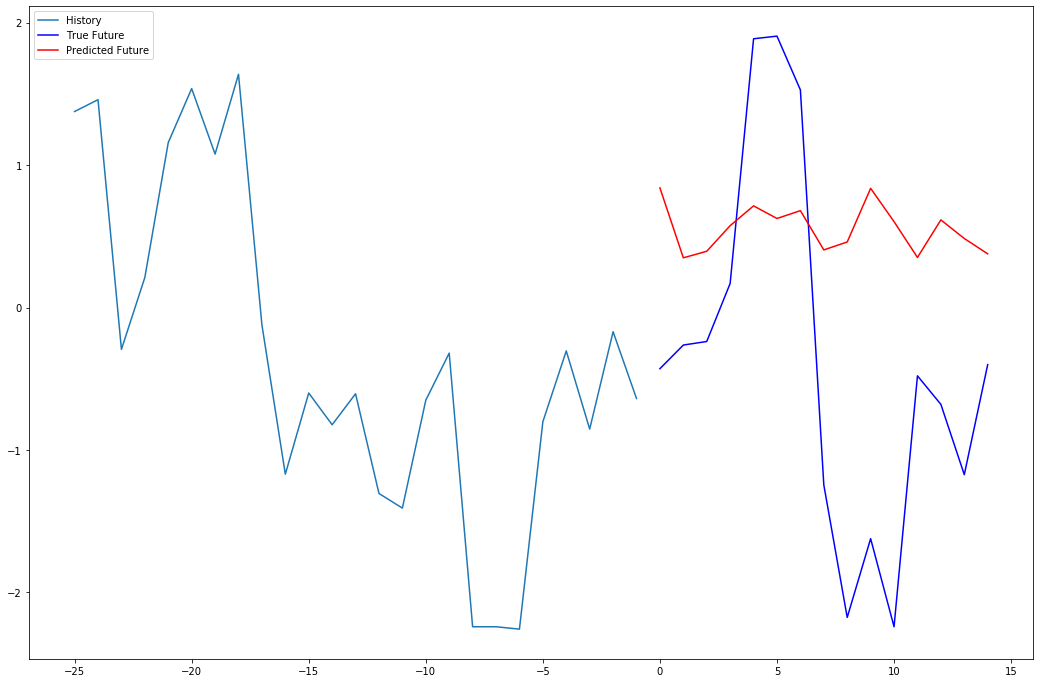

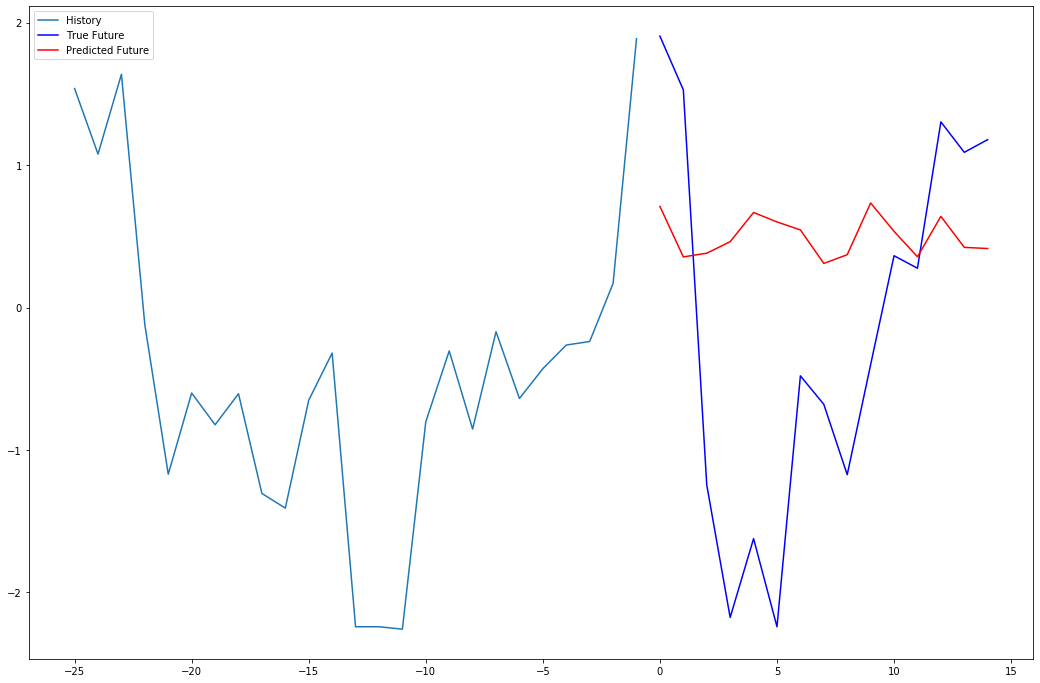

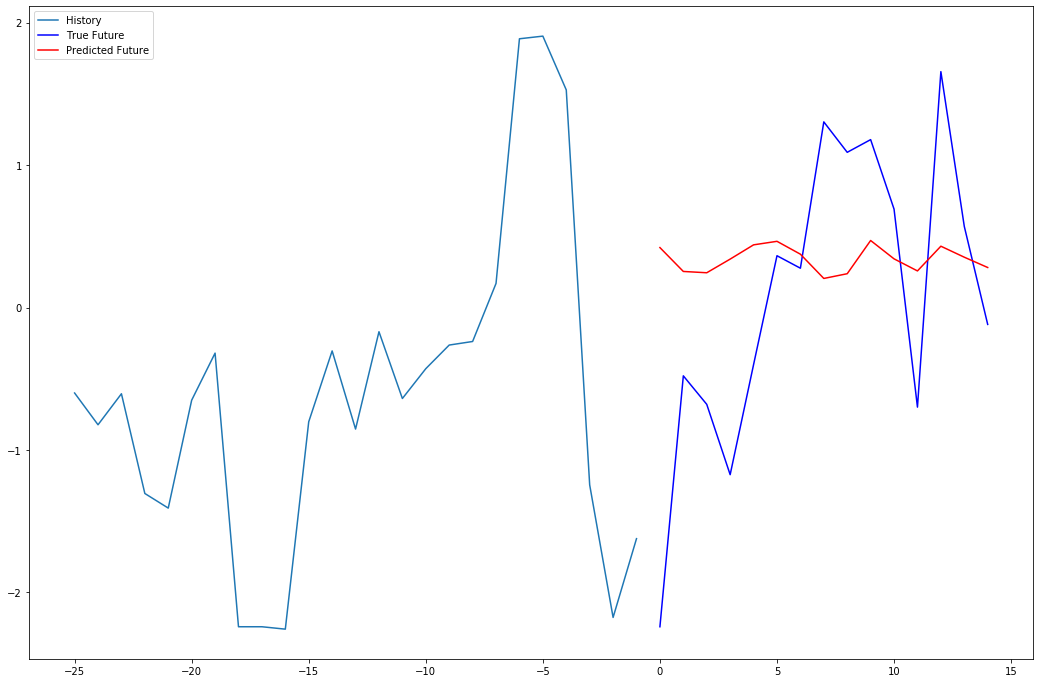

In [415]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])
#   print('Predicted : {}'.format(multi_step_model.predict(x)[0]))
#   print('Actual : {}'.format(y[0]))
#   print('Difference : {}'.format(multi_step_model.predict(x)[0]-(y[0])))

In [42]:
df_train.shape

(1838283, 149)

In [38]:
# Separate training and testing data
mask_val = [(df_cumulative.index.year == 2010) & (df_cumulative['ID_SC'].values==16)]
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))
print('NOTE: we will use CV on the train data below to define model training and testing data,\n  so have called the withheld data *validation* data here')

# Construct X and y
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]


X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

numFeatures = len(X_train.columns.to_list())
feature_labels = X_train.columns.to_list()

validation data shape = (55210, 149)
train data shape = (1838283, 149)
NOTE: we will use CV on the train data below to define model training and testing data,
  so have called the withheld data *validation* data here


In [49]:
#from sklearn.preprocessing import RobustScaler

from sklearn import preprocessing


In [9]:
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

y_train[y_train == 0] = 0.0001
y_val[y_val == 0] = 0.0001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))




In [10]:
X_train.head(5)

,SC_AACGM_LAT,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,Bz,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
Datetimes,,,,,,,,,,,,,,,,,,,,,
1987-01-12 12:57:00,51.143220,6.0,-0.246153,-0.969231,0.205104,0.97874,0.996134,0.087845,68.9,2.78,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1987-01-12 12:58:00,54.137207,6.0,-0.250380,-0.968148,0.205104,0.97874,0.992626,0.121216,68.9,2.78,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1987-01-12 13:01:00,62.928176,6.0,-0.263031,-0.964787,0.205104,0.97874,0.968006,0.250928,68.9,1.13,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
1987-01-12 13:02:00,65.719631,6.0,-0.267238,-0.963630,0.205104,0.97874,0.950633,0.310316,68.9,1.13,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
1987-01-12 13:03:00,68.392364,6.0,-0.271440,-0.962455,0.205104,0.97874,0.924624,0.380881,68.9,1.13,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AED68F4908>],
      dtype=object)

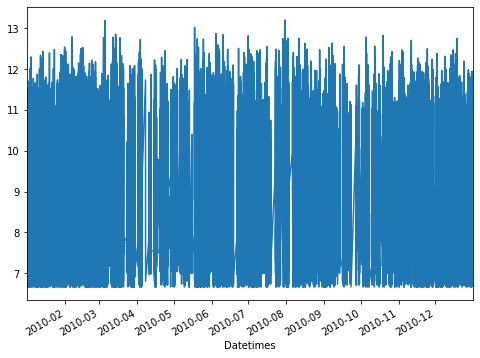

In [22]:
y_val_log.plot(subplots=True)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AED8B2E4A8>],
      dtype=object)

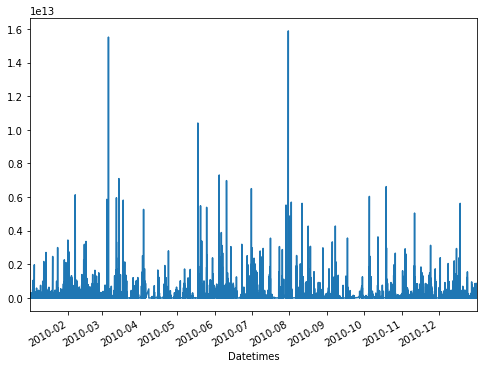

In [23]:
y_val.plot(subplots=True)

# New Model

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
#df=pd.read_csv('household_power_consumption.txt', delimiter=';')
#print('Number of rows and columns:', df.shape)
#df.head(5)

In [161]:
DMSP_DATA_DIR = r'F:\Astra'

In [240]:
file_load_df_cumulative = 'ML_DB_subsamp_ext_full_dfCumulative_complexHemisphereCombine.csv'
df = pd.read_csv(os.path.join(DMSP_DATA_DIR,file_load_df_cumulative))
#df_cumulative = df_cumulative.set_index('Datetimes')
#df_cumulative.index = pd.to_datetime(df_cumulative.index)

cols_to_drop_validation = [c for c in df.columns if ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
# cols_to_drop_validation = [c for c in df.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('5min' in c) | ('15min' in c) | ('newell' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]

df = df.drop(columns=cols_to_drop_validation)

In [241]:
df['Datetimes']=pd.to_datetime(df['Datetimes'])

In [242]:
df['year'] = df['Datetimes'].apply(lambda x: x.year)
df['quarter'] = df['Datetimes'].apply(lambda x: x.quarter)
df['month'] = df['Datetimes'].apply(lambda x: x.month)
df['day'] = df['Datetimes'].apply(lambda x: x.day)
df=df.loc[:,['Datetimes','ELE_TOTAL_ENERGY_FLUX', 'year','quarter','month','day']]
df.sort_values('Datetimes', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["Datetimes"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print('Number of rows and columns:', df.shape)
print('The time series starts from: ', df.Datetimes.min())
print('The time series ends on: ', df.Datetimes.max())

Number of rows and columns: (1947016, 7)
The time series starts from:  1987-01-12 12:57:00
The time series ends on:  2014-12-31 23:59:00


In [243]:
df.head(5)

,Datetimes,ELE_TOTAL_ENERGY_FLUX,year,quarter,month,day,weekday
0,1987-01-12 12:57:00,205782700.0000,1987,1,1,12,1
1,1987-01-12 12:58:00,250983700.0000,1987,1,1,12,1
2,1987-01-12 13:01:00,446914600.0000,1987,1,1,12,1
3,1987-01-12 13:02:00,19348490000.0000,1987,1,1,12,1
4,1987-01-12 13:03:00,391333700000.0000,1987,1,1,12,1


# apply box cox

In [196]:
from scipy.stats import boxcox

def box_cox(df, column_name):
    for column in column_name:
        df[column] = boxcox(df[column] + 1)[0]
    return df


In [197]:
column_name = ['ELE_TOTAL_ENERGY_FLUX']
box_cox(df, column_name)

,Datetimes,ELE_TOTAL_ENERGY_FLUX,year,quarter,month,day,weekday
0,1987-01-12 12:57:00,8.4582,1987,1,1,12,1
1,1987-01-12 12:58:00,8.4865,1987,1,1,12,1
2,1987-01-12 13:01:00,8.5657,1987,1,1,12,1
3,1987-01-12 13:02:00,8.9832,1987,1,1,12,1
4,1987-01-12 13:03:00,9.2192,1987,1,1,12,1
...,...,...,...,...,...,...,...
1947011,2014-12-31 23:54:00,8.1583,2014,4,12,31,1
1947012,2014-12-31 23:55:00,8.1094,2014,4,12,31,1
1947013,2014-12-31 23:56:00,8.0466,2014,4,12,31,1
1947014,2014-12-31 23:58:00,8.1539,2014,4,12,31,1


# Statistical Normality Test

In [244]:
stat, p = stats.normaltest(df.ELE_TOTAL_ENERGY_FLUX)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=12023385.673, p=0.000
Data does not look Gaussian (reject H0)


Kurtosis of normal distribution: 246344.87192010178
Skewness of normal distribution: 473.4238544530758


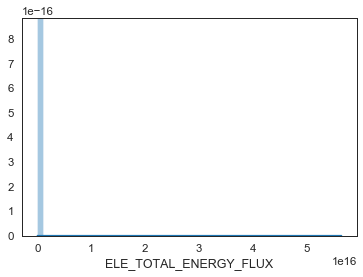

In [245]:
sns.distplot(df.ELE_TOTAL_ENERGY_FLUX);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.ELE_TOTAL_ENERGY_FLUX)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.ELE_TOTAL_ENERGY_FLUX)))

#### Data is heavily skewed 
#### the kurtosis is greater than zero, the distribution has heavier tails

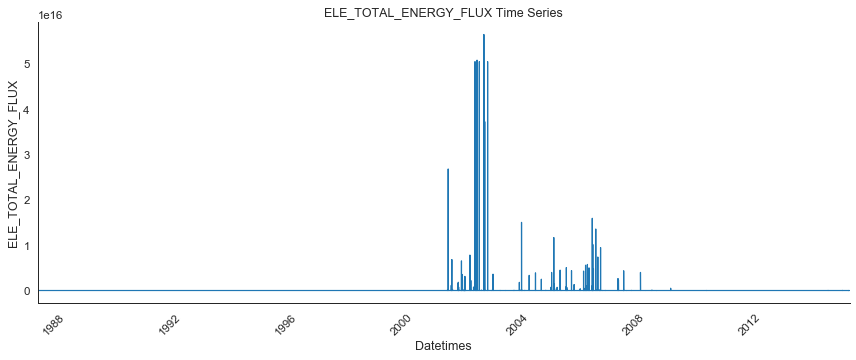

In [246]:
df1=df.loc[:,['Datetimes','ELE_TOTAL_ENERGY_FLUX']]
df1.set_index('Datetimes',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('ELE_TOTAL_ENERGY_FLUX')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('ELE_TOTAL_ENERGY_FLUX Time Series')
sns.despine(top=True)
plt.xticks(rotation=45, ha="right")
plt.show();

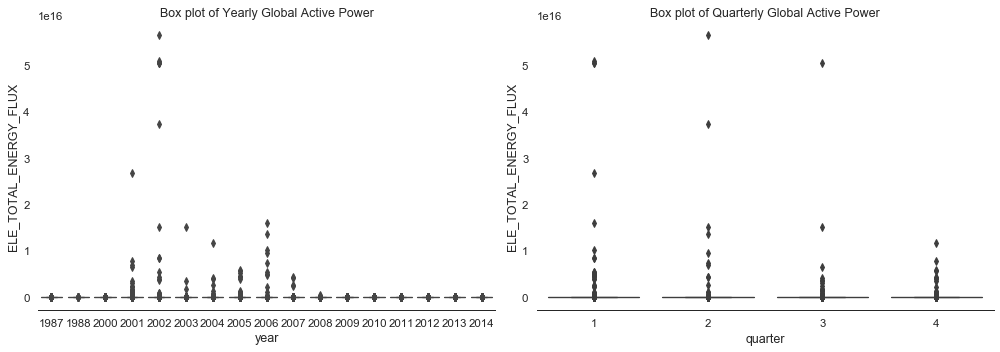

In [247]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="ELE_TOTAL_ENERGY_FLUX", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="ELE_TOTAL_ENERGY_FLUX", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();

,count,mean,std,min,25%,50%,75%,max
ELE_TOTAL_ENERGY_FLUX,1947016.0000,348056402745.2363,95001649051335.7344,2632692.0000,169601575.0000,554423050.0000,13047347500.0000,56482570000000000.0000


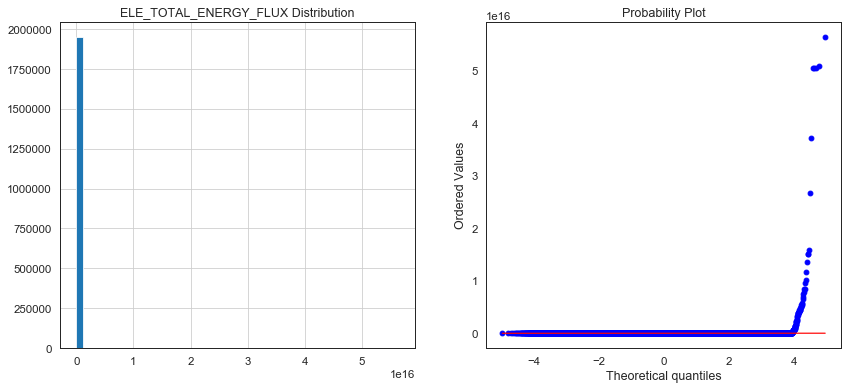

In [248]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['ELE_TOTAL_ENERGY_FLUX'].hist(bins=50)
plt.title('ELE_TOTAL_ENERGY_FLUX Distribution')
plt.subplot(1,2,2)
stats.probplot(df['ELE_TOTAL_ENERGY_FLUX'], plot=plt);
df1.describe().T

#### Average Global Active Power Resampled Over Day, Week, Month, Quarter and Year

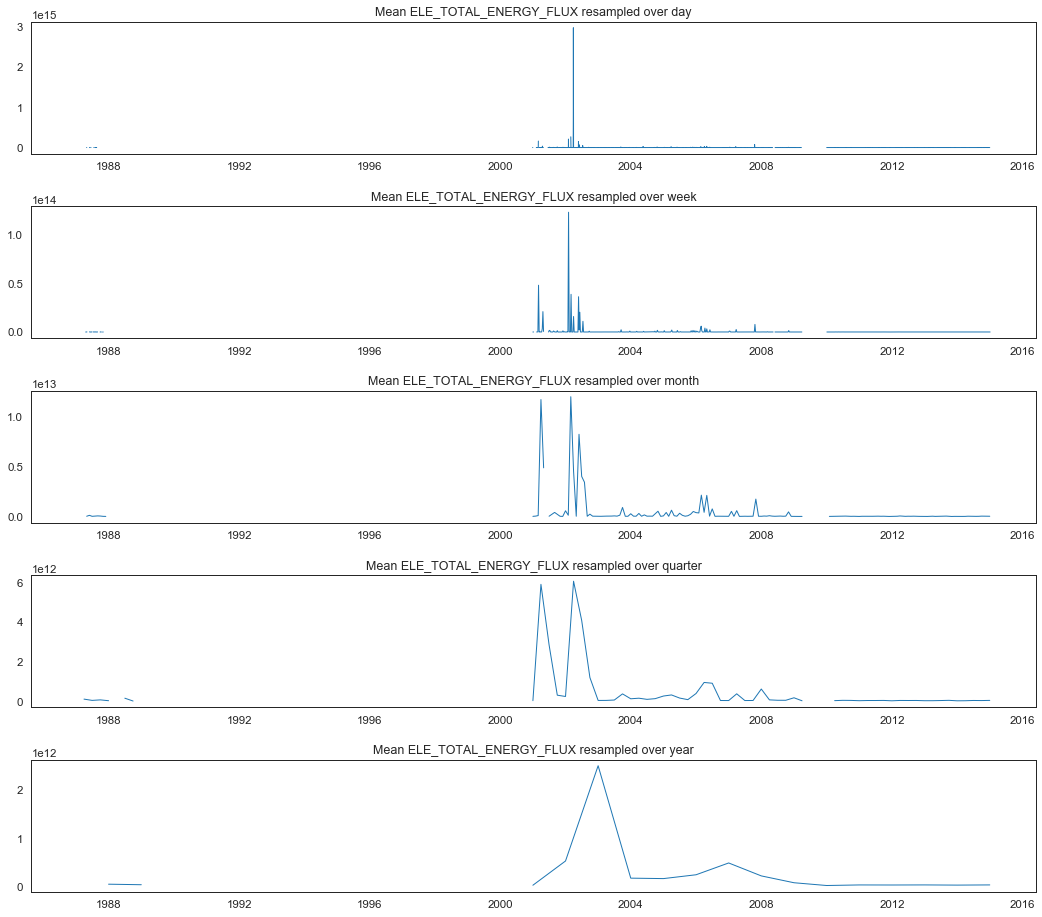

In [249]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['ELE_TOTAL_ENERGY_FLUX'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean ELE_TOTAL_ENERGY_FLUX resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['ELE_TOTAL_ENERGY_FLUX'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean ELE_TOTAL_ENERGY_FLUX resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['ELE_TOTAL_ENERGY_FLUX'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean ELE_TOTAL_ENERGY_FLUX resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['ELE_TOTAL_ENERGY_FLUX'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean ELE_TOTAL_ENERGY_FLUX resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['ELE_TOTAL_ENERGY_FLUX'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean ELE_TOTAL_ENERGY_FLUX resampled over year')
ax5.tick_params(axis='both', which='major');

From this we can see that the highest Energy flux was in 2009-2009

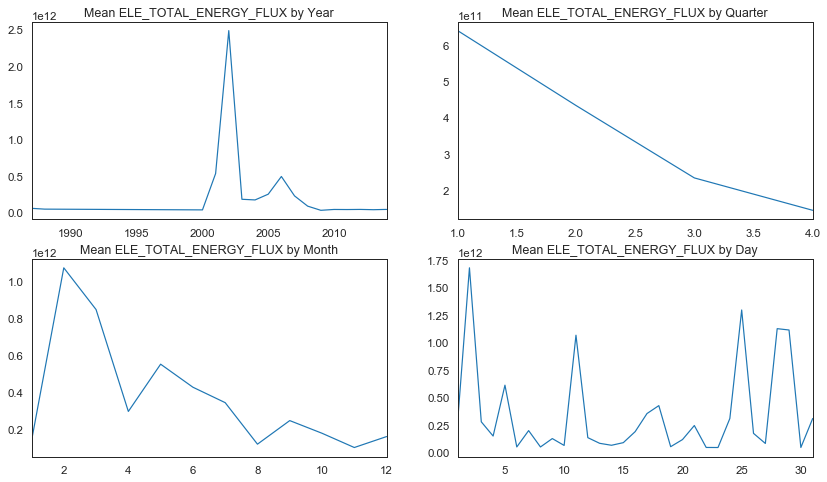

In [250]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').ELE_TOTAL_ENERGY_FLUX.agg('mean').plot()
plt.xlabel('')
plt.title('Mean ELE_TOTAL_ENERGY_FLUX by Year')

plt.subplot(2,2,2)
df.groupby('quarter').ELE_TOTAL_ENERGY_FLUX.agg('mean').plot()
plt.xlabel('')
plt.title('Mean ELE_TOTAL_ENERGY_FLUX by Quarter')

plt.subplot(2,2,3)
df.groupby('month').ELE_TOTAL_ENERGY_FLUX.agg('mean').plot()
plt.xlabel('')
plt.title('Mean ELE_TOTAL_ENERGY_FLUX by Month')

plt.subplot(2,2,4)
df.groupby('day').ELE_TOTAL_ENERGY_FLUX.agg('mean').plot()
plt.xlabel('')
plt.title('Mean ELE_TOTAL_ENERGY_FLUX by Day');

This shows us the spikes over time. We can see the the 3rd quarter is usually the highest in energy flux
we can see that the month of August/September are the highest. 
we can see that the year 2008-2009 was the hardest hit
and we can see there is general fluxations thoughout the month

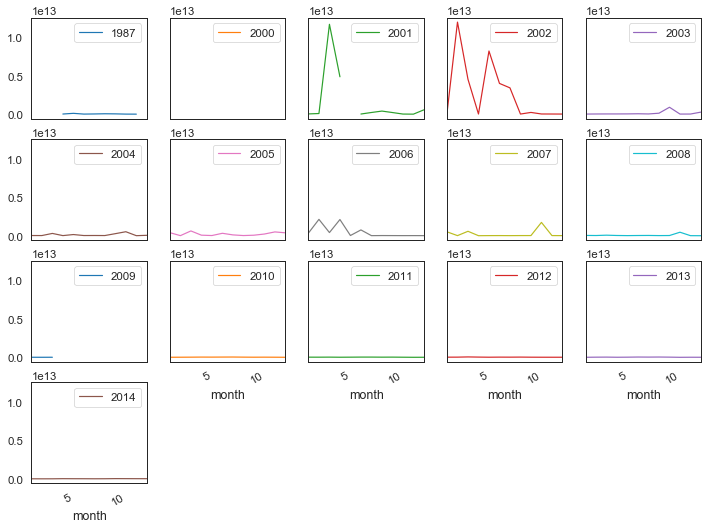

In [251]:
pd.pivot_table(df.loc[df['year'] != 1988], values = "ELE_TOTAL_ENERGY_FLUX", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(5, 5), sharey=True);

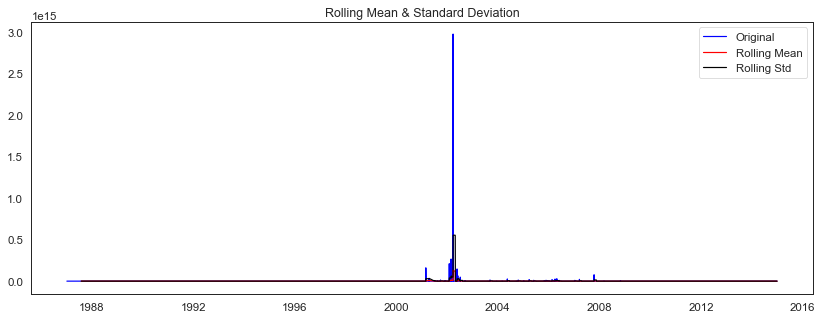

<Results of Dickey-Fuller Test>
Test Statistic                 -44.0878
p-value                          0.0000
#Lags Used                       1.0000
Number of Observations Used   4494.0000
Critical Value (1%)             -3.4318
Critical Value (5%)             -2.8622
Critical Value (10%)            -2.5671
dtype: float64


In [252]:
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.ELE_TOTAL_ENERGY_FLUX.dropna())

##### p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [266]:
dataset = df.ELE_TOTAL_ENERGY_FLUX.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 60
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [275]:
past_history = 60 #past data points (60 min in)
future_target = 5 #what data point predict(30 min in)
STEP = 3 #adjustment for iterations/steps similar to epocks
EVALUATION_INTERVAL = 75 #epoch will only run for 200 steps
EPOCHS = 10
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [270]:
model = Sequential()
model.add(LSTM(8, input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Train on 1557551 samples, validate on 389343 samples
Epoch 1/10
1557551/1557551 [==============================] - 33s 21us/sample - loss: 1.2730e-04 - val_loss: 8.9694e-05
Epoch 2/10
1557551/1557551 [==============================] - 31s 20us/sample - loss: 1.4076e-04 - val_loss: 1.4746e-04
Epoch 3/10
1557551/1557551 [==============================] - 32s 20us/sample - loss: 1.1894e-04 - val_loss: 3.2117e-05
Epoch 4/10
1557551/1557551 [==============================] - 31s 20us/sample - loss: 1.0493e-04 - val_loss: 1.3476e-04
Epoch 5/10
1557551/1557551 [==============================] - 31s 20us/sample - loss: 1.1347e-04 - val_loss: 7.3131e-05
Epoch 6/10
1557551/1557551 [==============================] - 31s 20us/sample - loss: 1.3010e-04 - val_loss: 6.5216e-05
Epoch 7/10
1557551/1557551 [==============================] - 32s 20us/sample - loss: 1.2315e-04 - val_loss: 1.1762e-04
Epoch 8/10
1557551/1557551 [==============================] - 32s 21us/sample - loss: 1.4260e-04 - val_loss

In [271]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 12557464983995.586
Train Root Mean Squared Error: 106870028106038.98
Test Mean Absolute Error: 12181711915759.172
Test Root Mean Squared Error: 12183293981372.504


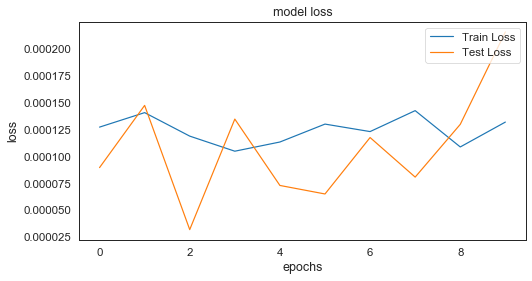

In [272]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

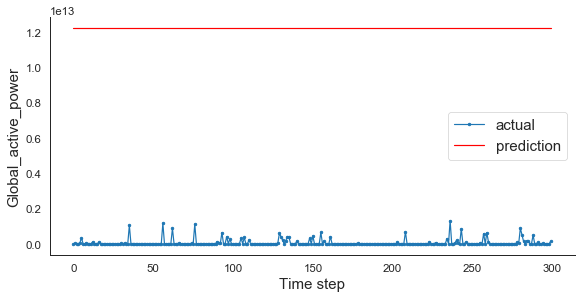

In [273]:
aa=[x for x in range(300)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:300], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:300], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [276]:
train_data_single = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

ValueError: Dimensions 1557551 and 1 are not compatible